In [5]:
'''
AUTHOR: Conor Lane, April 2023,  Conor.lane1995@gmail.com
Performs Single Value Decomposition on the epoched traces for a single cell and uses the output to plot frequency and intensity tuning. 
Inputs: takes the dictionary of tuned cells from "cells.pkl", assumes epoch_recording script has been run already.

'''

'\nAUTHOR: Conor Lane, April 2023,  Conor.lane1995@gmail.com\nPerforms Single Value Decomposition on the epoched traces for a single cell and uses the output to plot frequency and intensity tuning. \nInputs: takes the dictionary of tuned cells from "cells.pkl", assumes epoch_recording script has been run already.\n\n'

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import json
import os
from scipy.optimize import curve_fit
from scipy.stats import pearsonr

INPUT_DESIRED_CELL = 2

In [7]:
cell = "C:/Users/Conor/Documents/Imaging_Data/Two-Photon/Psilocybin_Project/Evoked_Cohort_Mice/ID269/ID269_08032023_psilocybin/TSeries-03082023-1211-066/suite2p/plane0/cells.pkl"

with open(cell, 'rb') as f:
    cell_dict_1 = pickle.load(f)

In [8]:
#Cell_ID selects the particular cell you want to look at. 
# Accesses the keys for all frequencies, all intensities and all trials. 
cell_ID = cell_dict_1[INPUT_DESIRED_CELL]
cell0 = cell_ID['traces']
nfreq = list(cell_ID['traces'].keys())
nInt = list(cell_ID['traces'][nfreq[0]].keys())
ntrial = list(cell_ID['traces'][nfreq[0]][nInt[0]].keys())
print(nfreq, nInt, ntrial)

[4364, 5371, 6612, 8140, 10020, 12335, 15184, 18691, 23009, 28324, 34867, 42922] [35, 50, 65, 80] [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [9]:
# Create a matrix of dimensions nFreq x nInte x nTrials to apply SVD to. 


matrix = np.array([[[cell0[i][j][k] for k in ntrial] for j in nInt] for i in nfreq])
print(matrix.shape)

(12, 4, 10, 15)


In [10]:
# Average the matrix across trials
matrix_av = matrix.mean(axis=2)

# Reshape the matrix so that the baseline mean is subtracted from the mean of the response.  
matrix_res = matrix_av[:,:,5:].mean(axis=-1) - matrix_av[:,:,:5].mean(axis=-1)
print(matrix_av.shape)
print(matrix_res.shape)

(12, 4, 15)
(12, 4)


(12, 12) (4,) (4, 4)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '4364'),
  Text(1, 0, '5371'),
  Text(2, 0, '6612'),
  Text(3, 0, '8140'),
  Text(4, 0, '10020'),
  Text(5, 0, '12335'),
  Text(6, 0, '15184'),
  Text(7, 0, '18691'),
  Text(8, 0, '23009'),
  Text(9, 0, '28324'),
  Text(10, 0, '34867'),
  Text(11, 0, '42922')])

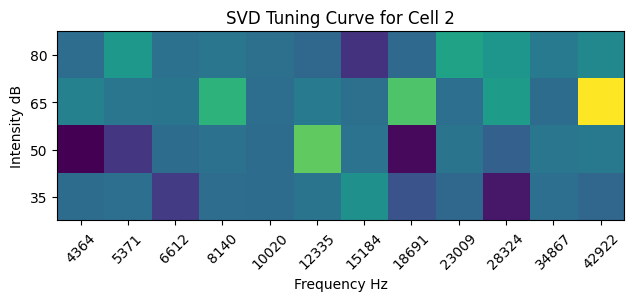

In [11]:
#Run Single Value Decomposition on the reshaped matrix and plot the resulting tuning heatmap. 

U, S, Vt = np.linalg.svd(matrix_res)
print(U.shape, S.shape, Vt.shape)
fig, ax = plt.subplots()
plt.tight_layout()
plt.imshow(matrix_res.T)
plt.gca().invert_yaxis()
plt.title("SVD Tuning Curve for Cell " + str(INPUT_DESIRED_CELL))
plt.xlabel("Frequency Hz")
plt.ylabel("Intensity dB")
plt.yticks(np.arange(len(nInt)))
plt.xticks(np.arange(len(nfreq)))
ax.set_xticklabels(nfreq)
ax.set_yticklabels(nInt)
plt.xticks(rotation = 45)



C:\Users\Conor\AppData\Local\Temp\ipykernel_8496\1325778369.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(nInt)


Text(0.5, 25.722222222222214, 'Singular Value')

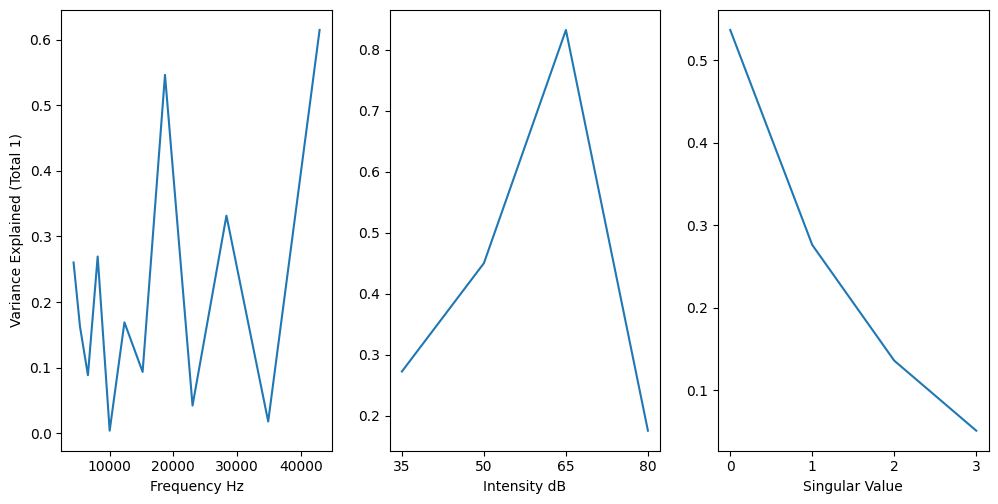

In [12]:
# Left: Plots the tuning curve of the cell (inverted so it looks classical), Middle: Plots the intensity tuning of the cell. Right: The level of significance of each 
# component, e.g. if the line starts close to 1.0, it means most of the variation is explained by the first component - cell is highly frequency tuned. 

U, S, Vt = np.linalg.svd(matrix_res)
fig, ax = plt.subplots(ncols=3, figsize=(10,5))
plt.tight_layout()
ax[0].plot(nfreq, np.abs(U[:,0]))
ax[0].set_xlabel("Frequency Hz")
ax[0].set_ylabel("Variance Explained (Total 1)")
ax[1].plot(np.abs(Vt[0]))
ax[1].set_xlabel("Intensity dB")
ax[1].set_xticklabels(nInt)
ax[1].set_xticks(np.arange(len(nInt)))
ax[2].plot(S**2/(S**2).sum())
ax[2].set_xlabel("Singular Value")

In [13]:
print(np.argmax(np.abs((Vt[0]))))
print(float(np.argmax(np.abs(U[:,0]))))


2
11.0


In [14]:
def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x, y = xy
    theta=0
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

In [15]:
amplitude = np.sum(matrix_res)
xo =  float(np.argmax(np.abs((Vt[0]))))
yo =  float(np.argmax(np.abs(U[:,0])))
sigma_x = 1
sigma_y = 1
theta = 0
offset = np.min(matrix_res)

x,y = np.meshgrid(np.arange(4),np.arange(12))

popt, pcov = curve_fit(twoD_Gaussian, (x, y), matrix_res.flatten(), p0=(amplitude,xo,yo,sigma_x,sigma_y,theta,offset), maxfev=5000)

C:\Users\Conor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[ 2.79082135e+02  2.10897869e+00  1.14194752e+01  4.55807520e-01
  2.37926814e-01  0.00000000e+00 -1.84960540e-01]
[[inf inf inf inf inf inf inf]
 [inf inf inf inf inf inf inf]
 [inf inf inf inf inf inf inf]
 [inf inf inf inf inf inf inf]
 [inf inf inf inf inf inf inf]
 [inf inf inf inf inf inf inf]
 [inf inf inf inf inf inf inf]]
0.39547960366639906


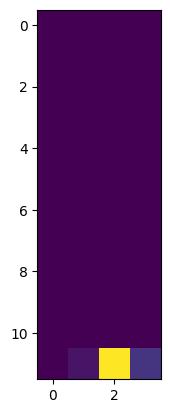

: 

In [16]:
print(popt)
print(pcov)
x,y = np.meshgrid(np.arange(4),np.arange(12))
plt.imshow(twoD_Gaussian((x,y),*popt).reshape(12,4))
print(pearsonr(twoD_Gaussian((x,y),*popt).reshape(12,4).mean(axis=1), np.abs(U[:,0])*popt[0])[0]**2)
# amplitude = AUC
# xo = preferred int
# yo = preferred freq
# sigma_x = int 
# sigma_y = width freq - stddev so how many freqs are within 65% of curve
# theta = rotation of gaussian
# offset = background baseline flourescence